In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
import seaborn as sns

In [2]:
# takes roughly ~5mins to run
# -- loading in tracking data with zone/man probs

all_data = []

for week_eval in [9]:

  preds_week = pd.read_csv(f"/home/sam/repos/hobby-repos/nfl/data/processed/tracking_week_{week_eval}_preds.csv")
  print(preds_week.head())
  all_data.append(preds_week)
  print(f"Finished processing week {week_eval}...")

all_weeks = pd.concat(all_data, ignore_index=True)
all_weeks['base_correct'] = all_weeks['pred'] == all_weeks['actual']
print(all_weeks.head())

       gameId  playId    nflId      displayName  frameId    frameType  \
0  2022110700      56  33131.0  Calais Campbell        1  BEFORE_SNAP   
1  2022110700      56  33131.0  Calais Campbell        1  BEFORE_SNAP   
2  2022110700      56  33131.0  Calais Campbell        2  BEFORE_SNAP   
3  2022110700      56  33131.0  Calais Campbell        2  BEFORE_SNAP   
4  2022110700      56  33131.0  Calais Campbell        3  BEFORE_SNAP   

                    time  jerseyNumber club playDirection  ...  defense  week  \
0  2022-11-08 01:16:09.2          93.0  BAL          left  ...        1     9   
1  2022-11-08 01:16:09.2          93.0  BAL          left  ...        1     9   
2  2022-11-08 01:16:09.3          93.0  BAL          left  ...        1     9   
3  2022-11-08 01:16:09.3          93.0  BAL          left  ...        1     9   
4  2022-11-08 01:16:09.4          93.0  BAL          left  ...        1     9   

        uniqueId    frameUniqueId  snap_frame  frames_from_snap  zone_prob

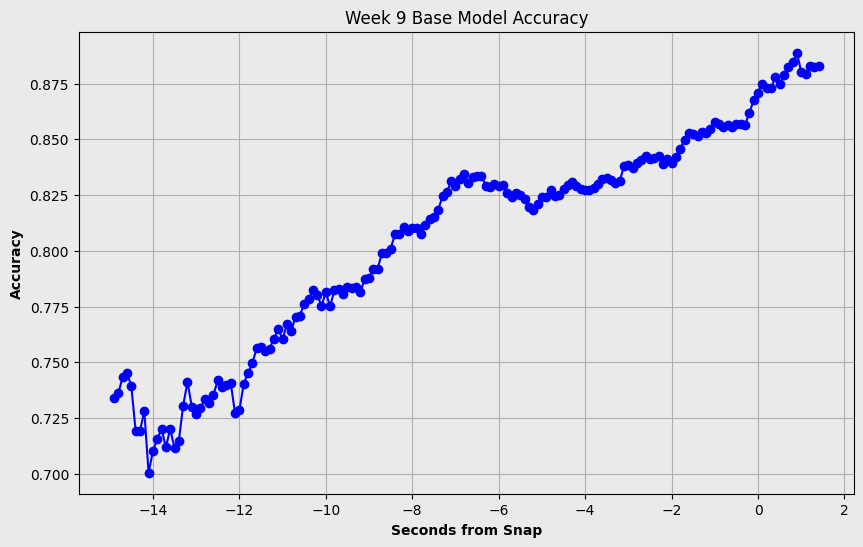

In [3]:
# filter for right frames -- week 9 for vis

week_9_accuracy = all_weeks[(all_weeks['week'] == 9) & (all_weeks['frames_from_snap'] < 15) & (all_weeks['frames_from_snap'] > -150)]
week_9_accuracy['seconds_from_snap'] = week_9_accuracy['frames_from_snap'] / 10

accuracy_by_frame = week_9_accuracy.groupby('seconds_from_snap')['base_correct'].mean()

plt.figure(figsize=(10, 6), facecolor="#EAEAEA")
plt.plot(accuracy_by_frame.index, accuracy_by_frame.values, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Seconds from Snap', fontweight='bold')
plt.ylabel('Accuracy',fontweight='bold')
plt.title('Week 9 Base Model Accuracy')
plt.grid(True)
ax = plt.gca()
ax.set_facecolor("#EAEAEA")
plt.show()

In [4]:

# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# %matplotlib widget

# # Subset and compute seconds from snap
# special_df = all_weeks[
#     (all_weeks['uniqueId'] == "2022110603_796") &
#     (all_weeks['frames_from_snap'] < 300) &
#     (all_weeks['frames_from_snap'] > -200)
# ].copy()

# special_df['seconds_from_snap'] = special_df['frames_from_snap'] / 10
# special_df = special_df.sort_values('seconds_from_snap')

# # --- Set up figure ---
# fig, ax = plt.subplots(figsize=(10, 6), facecolor="#EAEAEA")
# ax.set_xlabel('Seconds from Snap', fontweight='bold')
# ax.set_ylabel('Man Probability', fontweight='bold')
# ax.set_title('Lazard Play')
# ax.grid(True)

# # Empty line object that we'll update
# (line,) = ax.plot([], [], color="tab:blue", lw=2, label="Probability")

# # Set x/y limits once
# ax.set_xlim(special_df['seconds_from_snap'].min(), special_df['seconds_from_snap'].max())
# ax.set_ylim(0, 1)  # assuming probabilities in [0,1]
# ax.legend()

# # --- Animation update function ---
# def init():
#     line.set_data([], [])
#     return (line,)

# def update(frame):
#     # up to frame index
#     x = special_df['seconds_from_snap'].iloc[:frame]
#     y = special_df['zone_prob'].iloc[:frame]
#     line.set_data(x, y)
#     return (line,)

# # --- Build animation ---
# ani = animation.FuncAnimation(
#     fig,
#     update,
#     frames=len(special_df),
#     init_func=init,
#     blit=True,
#     interval=1,  # milliseconds per frame (lower = faster)
# )

# plt.tight_layout()
# plt.show()
